In [1]:
#!python -m pip install mitoinstaller
#!python -m mitoinstaller install

In [78]:
# Import of packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
# from pandas_profiling import ProfileReport
data_dir = Path("./data")

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">
  <h1 style="color: #3b3b3b">🤓📚 Exploring the impact of Covid19 on Online Education</h1>
</div>

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">
<h2 style="color: #3b3b3b">🌎 Overview</h2>

<h3 style="color: #3b3b3b">🤔💭 Research question</h3>

**Does race or economical background of a district play a role in online learning adoption?**

To answer this question we'll...
    
1. ...create a metric to compare privileged from underserved districts
2. ...compare engagement pre- and post-Covid19 in each group
3. ...compare the two groups to each other

<h3 style="color: #3b3b3b">🗓📌 Available data</h3>

<h4 style="color: #3b3b3b">What does the data include?</h4>

- Two measures of learning engagement  (`pct_access` and `engagement_index`) aggregated over **234** US school districts.
- The top **372** ed-tech products (out of **10000**) identified by the Chrome browser extension [learnplatform](https://learnplatform.com/).


<h4 style="color: #3b3b3b">💪 Engagement data</h4>
    
How engaged students are given a tool and a district.

| Name             | Description |
|------------------|-------------|
| time             | date in "YYYY-MM-DD" |
| lp_id            | The unique identifier of the product |
| pct_access       | Occurance/absence of engagement. Ratio of engaged students |
| engagement_index | Engagement level |

<h5 style="color: #3b3b3b">Analysis of `pct_access` and `engagement_index` values</h5>

- `pct_access`: Percentage of students in the district have at least one page-load event of a given product and on a given day

    - **What?**: Indication of the number of students who engage with online education tools.
    - **Example**: 15% of students in a district in Utah engaged at least once with Google Docs on Monday April 14.
    - **Discussion**: There are values > 1. This probably indicates usage of multiple devices?!

- `engagement_index`: Total page-load events per one thousand students of a given product and on a given day

    - **What?**: Indication of how actively products are used. popular certain products are - not by how many students they .
    - **Example**: In a district in Colorado 341 Google Docs pages were loade per 1000 students on Monday April 14.

<h4 style="color: #3b3b3b">🌆🏡 District data </h4>
    
Information about **234** school districts in which the students' data was collected.

| Name                   | Description |
|------------------------|-------------|
| district_id            | The unique identifier of the school district |
| state                  | The state where district is located |
| locale                 | District classification: City, Suburban, Town or Rural |
| pct_black/hispanic     | Percentage of students in the districts identified as Black or Hispanic |
| pct_free/reduced       | Percentage of students in the districts eligible for free or reduced-price lunch  |
| countyconnectionsratio | ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) |
| pptotalraw             | Per-pupil total expenditure paid by schools (sum of local and federal expenditure) as median over all schools in district |

    
<h5 style="color: #3b3b3b">Privileged vs. underserved districts</h5>

Districts have different demographics. We used the `pct_black/hispanic` and `pct_free/reduced` data to compute a metric of underserved districts to explory whether Covid19 had a greater impact on either group.

</div>

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h2 style="color: #3b3b3b">🏁 Initial steps</h2>

<h3 style="color: #3b3b3b">💽 Engagement data for all districts: Load and concatenate</h3>

Before we begin with the fun part we have to load all the data we need and get it into a shape we can work with.

</div>

In [79]:
import glob
import pandas as pd 

all_file_names = list(data_dir.glob("engagement_data/*.csv"))
data_of_district = []

for filename in all_file_names:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.stem
    df["district_id"] = district_id
    data_of_district.append(df)

engagement = pd.concat(data_of_district)
engagement = engagement.reset_index(drop=True)
engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322.0,0.04,1.30,3188
1,2020-01-01,57084.0,0.04,0.43,3188
2,2020-01-01,99916.0,0.09,5.20,3188
3,2020-01-01,58235.0,0.00,NaN,3188
4,2020-01-01,11585.0,0.04,1.30,3188


<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">📍🏞 Districts data: Load + drop missing data</h3>

</div>

In [80]:
districts = pd.read_csv(data_dir /"districts_info.csv")
districts.dropna(inplace = True)
districts.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
5,5987,Wisconsin,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
6,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000["
7,7177,North Carolina,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[8000, 10000["


<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">⚖️ Districts data: Average anonymized data ranges</h3>
    
District data got heavily anonymized to conceal the identity of a district.

This lead to the following **side-effects**:

- Exact data points of several columns got replaced by equally spaced ranges
- Many missing values.

Before running analyses on the data we replace each range by its mean value:

</div>

In [81]:
from statistics import mean

for col in ['pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw', 'county_connections_ratio']:
    districts[col] = districts[col].apply(lambda val: mean([float(x) for x in val[1:-1].split(',')]))

districts.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,0.1,0.1,0.59,15000.0
2,4921,Utah,Suburb,0.1,0.3,0.59,7000.0
5,5987,Wisconsin,Suburb,0.1,0.1,0.59,11000.0
6,3710,Utah,Suburb,0.1,0.5,0.59,7000.0
7,7177,North Carolina,Suburb,0.3,0.3,0.59,9000.0


<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">🍹 Merge district and engagement data</h3>

Also add a column that holds an integer representation of the date on which the engagement event was recorded.

</div>

In [82]:
engagement['district_id'] = engagement['district_id'].astype('int64')
merged_data = pd.merge(engagement, districts, on = 'district_id')
merged_data = merged_data.dropna()

# Add time as integer
timeAsInt = [int("".join(x.split("-"))) for x in merged_data['time']]
merged_data['time_as_int'] = timeAsInt

merged_data.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,time_as_int
0,2020-01-01,95731.0,0.09,85.86,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101
1,2020-01-01,71805.0,0.09,3.47,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101
3,2020-01-01,57084.0,0.09,0.87,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101
6,2020-01-01,69863.0,0.09,0.87,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101
8,2020-01-01,13496.0,0.09,131.83,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101


<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h2 style="color: #3b3b3b">🦠 Pre- and Post Covid19</h2>

To analyze the impact of COVID-19 concerning district demographics we did the following: 

1. We split the data into two parts - **Before** and **after** March 11 2020
    
  - On **March 11 2020** the WHO declared COVID-19 a global Pandemic (as can be seen in [this timeline](https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020))

2. Grouped by district, we took computed means (of the values we're interested in, i.e. `pct_access` and `engagement_index`)

<h4 style="color: #3b3b3b">📆 Dates</h4>

- **March 11**: WHO Declares COVID-19 a Pandemic 
- US vacation time: Between **Mai 30** and **August 20**

</div>

In [84]:
covid_date_WHO_declares_pandemic = 20200311 # March 11 2020

us_vacation_start = 20200530
us_vacation_end = 20200820

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">✂︎ Split data and compute means</h3>

</div>

In [85]:
# Pre Covid19
data_pre = merged_data[merged_data['time_as_int'] <= covid_date_WHO_declares_pandemic]
pre_mean = data_pre.groupby(by=['district_id'], as_index=False).mean()

# Post Covid19
data_post = merged_data[merged_data['time_as_int'] > covid_date_WHO_declares_pandemic]
post_mean = data_post.groupby(by=['district_id'], as_index=False).mean()

In [201]:
# merged_data['pre-covid'] = merged_data['time_as_int'] <= covid_date_WHO_declares_pandemic
merged_data['pre_covid'] = merged_data['time_as_int'] <= covid_date_WHO_declares_pandemic

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">📐 Defining a metric</h3>
    
<h4 style="color: #3b3b3b">Privileged vs. under-served districts</h4>

Districts have different demographics. We used the `pct_black/hispanic` and `pct_free/reduced` data to compute a metric of underserved districts to explore whether Covid19 had a greater impact on either group.

Our assumption is that students in districts with a high percentage of black/hispanic people and a high number of free or reduced lunches on average may be disadvantaged a bit more and may have to struggle more in school.

As a measure we computed the sum of `pct_black/hispanic` and `pct_free/reduced`. If this value is lower than its average over all districts, we labeled the district as *privileged*. If not, we labeled it as *under-served*.

</div>

In [207]:
# Add 'underserved' column
merged_data_underserved_sum = merged_data['pct_free/reduced'] + merged_data['pct_black/hispanic']
merged_data_underserved_sum_average = mean(merged_data_underserved_sum)
merged_data['underserved'] = merged_data_underserved_sum > merged_data_underserved_sum_average

merged_data.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,time_as_int,pre_covid,underserved
0,2020-01-01,95731.0,0.09,85.86,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101,True,False
1,2020-01-01,71805.0,0.09,3.47,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101,True,False
3,2020-01-01,57084.0,0.09,0.87,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101,True,False
6,2020-01-01,69863.0,0.09,0.87,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101,True,False
8,2020-01-01,13496.0,0.09,131.83,1204,Utah,Suburb,0.1,0.1,0.59,7000.0,20200101,True,False


In [177]:
# Pre Covid19
pre_mean_underserved = pre_mean['pct_free/reduced'] + pre_mean['pct_black/hispanic']
pre_mean_underserved_average = mean(pre_mean_underserved)
pre_mean['underserved'] = pre_mean_underserved > pre_mean_underserved_average

# Post Covid19
post_mean_underserved = post_mean['pct_free/reduced'] + post_mean['pct_black/hispanic']
post_mean_underserved_average = mean(post_mean_underserved)
post_mean['underserved'] = post_mean_underserved > post_mean_underserved_average

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">👀 Comparing engagement data</h3>

We now plot both, `pct_access` and `engagement_index` in a scatter plot and compare `underserved` and `priveleged` districts
</div>


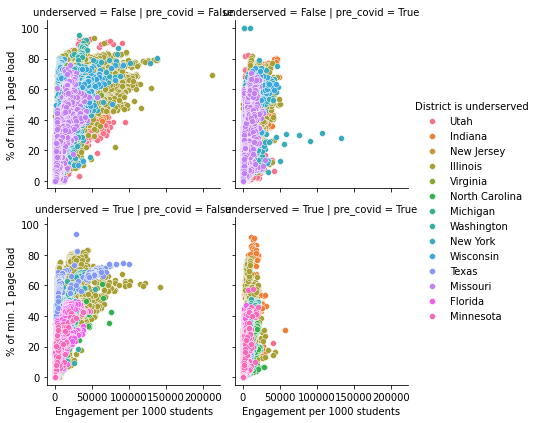

In [221]:
# Engagement_index vs. pct access
g = sns.FacetGrid(merged_data, row="underserved", col="pre_covid", hue="state")
# g.map(sns.scatterplot, "engagement_index", "pct_access").set(title="Districts - Pre Covid-19", xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g.map(sns.scatterplot, "engagement_index", "pct_access").set(xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g.add_legend(title="District is underserved")

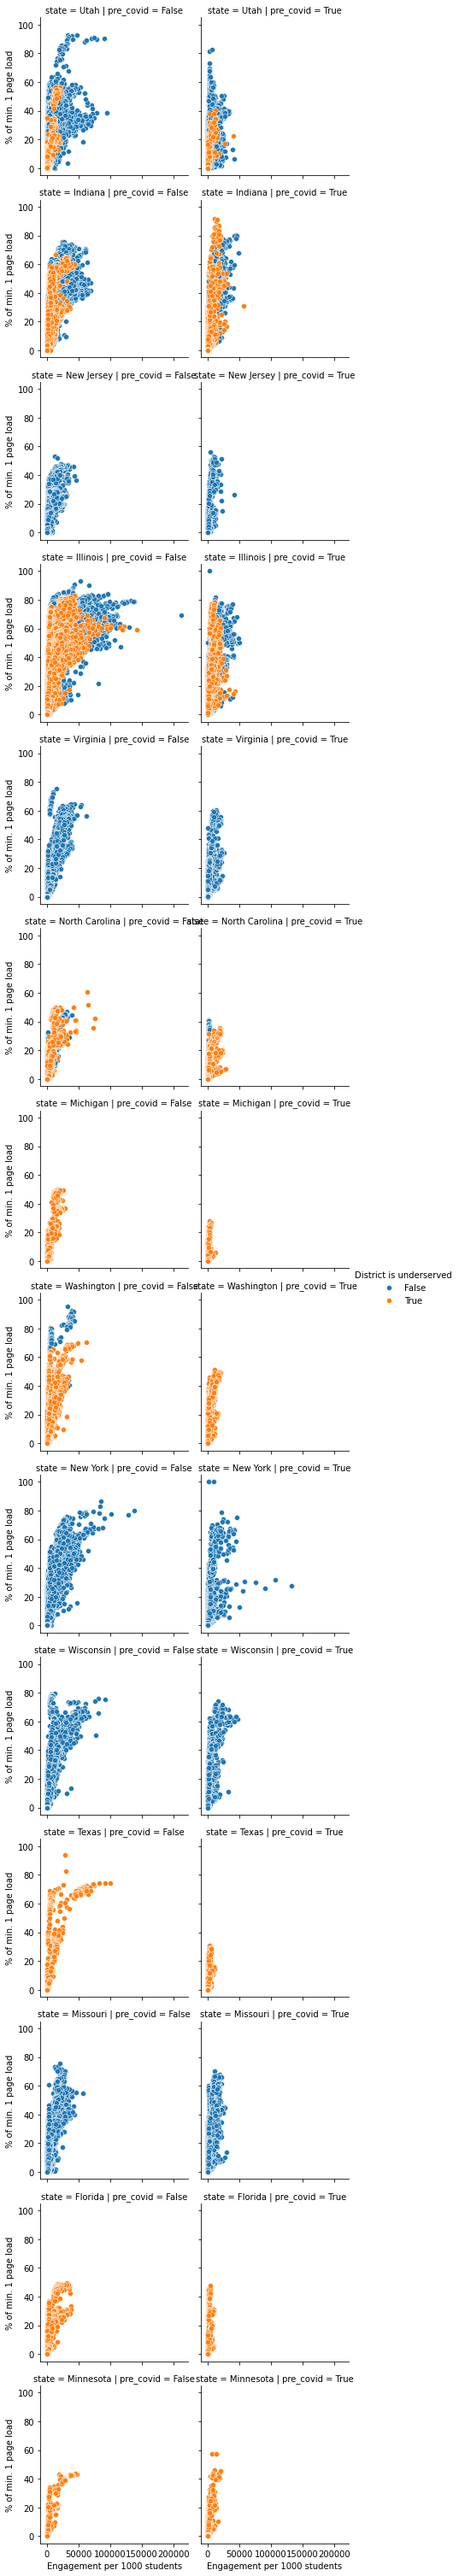

In [218]:
# Split by state
g = sns.FacetGrid(merged_data, hue="underserved", col="pre_covid", row="state")
# g.map(sns.scatterplot, "engagement_index", "pct_access").set(title="Districts - Pre Covid-19", xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g.map(sns.scatterplot, "engagement_index", "pct_access").set(xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g.add_legend(title="District is underserved")
# g.set_yticklabels(np.round(np.linspace(0, 3, 10), decimals=1))

In [215]:
merged_data['engagement_index'].sort_values().tail()

5847676    136953.23
9073264    137663.83
5842175    137953.80
2692898    142206.77
1074247    213045.47
Name: engagement_index, dtype: float64

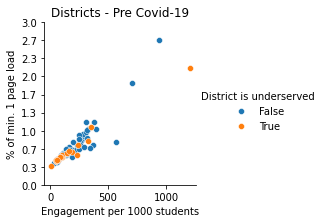

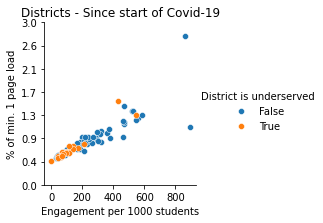

In [191]:
# Pre Covid19
g = sns.FacetGrid(pre_mean, hue="underserved")
g.map(sns.scatterplot, "engagement_index", "pct_access").set(title="Districts - Pre Covid-19", xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g.add_legend(title="District is underserved")
g.set_yticklabels(np.round(np.linspace(0, 3, 10), decimals=1))

# Post Covid19
g2 = sns.FacetGrid(post_mean, hue="underserved")
g2.map(sns.scatterplot, "engagement_index", "pct_access").set(title="Districts - Since start of Covid-19", xlabel="Engagement per 1000 students", ylabel="% of min. 1 page load")
g2.add_legend(title="District is underserved")
g2.set_yticklabels(np.round(np.linspace(0, 3, 8), decimals=1))

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">


<h4 style="color: #3b3b3b">👀 Analyzing the plots</h4>

<h5 style="color: #3b3b3b">pct_access vs. engagement_index</h5>
    
- `pct_access` and `engagement_index` seem to correlate at all times (pre- and post Covid-19). That's to be expected - it would 

<h5 style="color: #3b3b3b">Privileged vs. under-served districts</h5>

- Whether there is a difference between fine-grained differences are hard to see.
- There are less underserved districts than privileged districts (as seen in the piechart below)

</div>

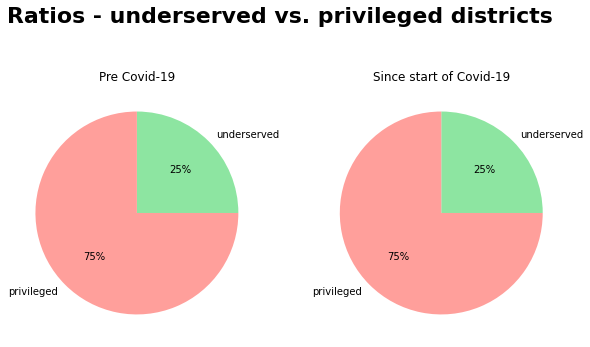

# of underserved districts (pre Covid-19):            21 / 84
# of underserved districts (since Covid-19 Outbreak): 22 / 88


In [188]:
# Compute counts
pre_mean_underserved_count = sum(pre_mean_underserved > pre_mean_underserved_average)
post_mean_underserved_count = sum(post_mean_underserved > post_mean_underserved_average)

# Pie plots to show 
colors = sns.color_palette('pastel')[2:4]
plt.figure(figsize=(10,6))
plt.suptitle("Ratios - underserved vs. privileged districts", fontsize=22, fontweight="bold")
plt.subplot(1,2,1)
plt.title('Pre Covid-19')
plt.pie([pre_mean_underserved_count, len(pre_mean) - pre_mean_underserved_count], labels=['underserved', 'privileged'], colors = colors, autopct='%.0f%%')
plt.subplot(1,2,2)
plt.title('Since start of Covid-19')
plt.pie([post_mean_underserved_count, len(post_mean) - post_mean_underserved_count], labels=['underserved', 'privileged'], colors = colors, autopct='%.0f%%')
plt.show()

# Ratio of underserved vs. privileged districts
print("# of underserved districts (pre Covid-19):           ", pre_mean_underserved_count, "/", len(pre_mean)) # 21
print("# of underserved districts (since Covid-19 Outbreak):", post_mean_underserved_count, "/", len(post_mean)) # 22

<div style="background-color: #f0f0f0; padding: 10px; border: 2px solid #4a4a4a; border-radius: 5px">

<h3 style="color: #3b3b3b">Comparing means</h3>
    
We analyze whether differences/similarities between privileged and under-served districts remain intact pre Covid-19 and after Covid-19 hit the US.

<h4 style="color: #3b3b3b">Privileged vs. under-served districts</h4>



</div>

(206.79376049613072,
 240.91744775303525,
 178.48894929511962,
 130.38255498242694)

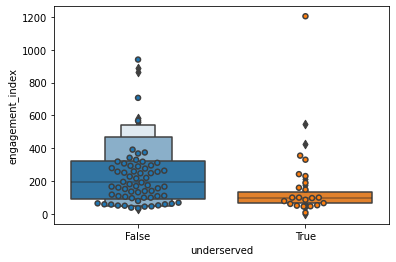

In [200]:
# Comparing means

post_engagement_index_under_served_mean = mean(post_mean[post_mean['underserved'] == False]['engagement_index'].dropna())
pre_engagement_index_under_served_mean = mean(pre_mean[pre_mean['underserved'] == False]['engagement_index'].dropna())

post_engagement_index_privileged_mean = mean(post_mean[post_mean['underserved'] == True]['engagement_index'].dropna())
pre_engagement_index_privileged_mean = mean(pre_mean[pre_mean['underserved'] == True]['engagement_index'].dropna())

ax = sns.swarmplot(x="underserved", y="engagement_index", data=pre_mean, linewidth=1.5)
sns.boxenplot(x="underserved", y="engagement_index", data=post_mean)


(pre_engagement_index_under_served_mean, post_engagement_index_under_served_mean, pre_engagement_index_privileged_mean, post_engagement_index_privileged_mean)

## Analysis: Difference of privileged vs. under-served districts

First comparison of means shows differences pre-covid and post-covid.

Whereas the engagement index 

In [34]:
st_acсess = merged_data.groupby(['state', 'time']).agg({'pct_access': 'mean'}).reset_index()
st_eng = merged_data.groupby(['state', 'time']).agg({'engagement_index': 'mean'}).reset_index()
# locale 
loc_acсess = merged_data.groupby(['locale', 'time']).agg({'pct_access': 'mean'}).reset_index()
loc_eng = merged_data.groupby(['locale', 'time']).agg({'engagement_index': 'mean'}).reset_index()
cat_acсess = merged_data.groupby(['Basic_category', 'time']).agg({'pct_access': 'mean'}).reset_index()
cat_eng = merged_data.groupby(['Basic_category', 'time']).agg({'engagement_index': 'mean'}).reset_index()

# for i in [st_acсess, st_eng, loc_acсess, loc_eng, cat_acсess, cat_eng]:
#     i['day_of_week'] = i['time'].dt.dayofweek